***Step 1: Extract the text from multiple CSV files***

In [1]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import os

# Directories for CSV files and output
input_directory = './CSV'
output_directory = './output'
output_file = 'combined_texts.txt'
output_path = os.path.join(output_directory, output_file)

# Create the output directory if it does not exist
os.makedirs(output_directory, exist_ok=True)

# Open the output file in write mode
with open(output_path, 'w') as outfile:
    # Loop through each file in the directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.csv'):
            # Load the CSV file
            df = pd.read_csv(os.path.join(input_directory, filename))
            # Extract the 'text' column (assuming it's named 'text')
            texts = df['TEXT'].dropna().tolist()
            # Write each text into the output file
            for text in texts:
                outfile.write(text + '\n')

print(f"Combined text file has been saved to {output_path}")


Combined text file has been saved to ./output/combined_texts.txt


***Step 2: Install the necessary libraries***

In [3]:
print("Installing SpaCy, SciSpacy, and the models...")
# !pip install spacy
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_sm-0.5.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz
print("Done.")

print("Installing Transformers...")
# !pip install transformers
print("Done.")

Installing SpaCy, SciSpacy, and the models...
Done.
Installing Transformers...
Done.


***Task 3.1: Count the Top 30 most common words***

In [4]:
from collections import Counter
import csv

# Parameters
input_file_path = './output/combined_texts.txt'
output_csv_path = './output/top_30_words(3-1).csv'
chunk_size = 1024

# Initialize a Counter object to count words
word_counter = Counter()

# Read the file chunk by chunk
with open(input_file_path, 'r', encoding='utf-8') as f:
    while True:
        chunk = f.read(chunk_size)
        if not chunk:
            break
        words = chunk.split()
        word_counter.update(words)

# Get the 30 most common words
top_30_words = word_counter.most_common(30)

# Save the word counts to a CSV file
with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Word', 'Count'])
    writer.writerows(top_30_words)

print(f"Top 30 words have been saved to {output_csv_path}")


Top 30 words have been saved to ./output/top_30_words(3-1).csv


In [5]:
pd.read_csv('./output/top_30_words(3-1).csv').head(5)

,Word,Count
0,and,1851664
1,the,1619517
2,to,1549937
3,of,1528256
4,was,1460160


***Task 3.2: Count unique tokens using the HuggingFace Auto Tokenizer***

In [6]:
from transformers import AutoTokenizer
from collections import Counter
import csv

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# File paths
input_file_path = './output/combined_texts.txt'
output_csv_path = './output/top_30_words(3-2).csv'
chunk_size = 512

# Initialize a Counter object to count tokens
token_counts = Counter()

# Read the file chunk by chunk
with open(input_file_path, 'r', encoding='utf-8') as f:
    while True:
        chunk = f.read(chunk_size)
        if not chunk:
            break
        chunk_tokens = tokenizer.tokenize(chunk)
        token_counts.update(chunk_tokens)

# Get the 30 most common tokens
top_30_tokens = token_counts.most_common(30)

# Save the token counts to a CSV file
with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Token', 'Count'])
    for token, count in top_30_tokens:
        writer.writerow([token, count])

print(f"Top 30 tokens have been saved to {output_csv_path}")


Top 30 tokens have been saved to ./output/top_30_words(3-2).csv


In [7]:
pd.read_csv('./output/top_30_words(3-2).csv').head(5)

,Token,Count
0,*,12214251
1,.,8947097
2,-,6203884
3,:,4059494
4,",",3666144


***Step 4: Named-Entity Recognition (NER)***

***NER with SciSpacy (en_ner_bc5cdr_md)***

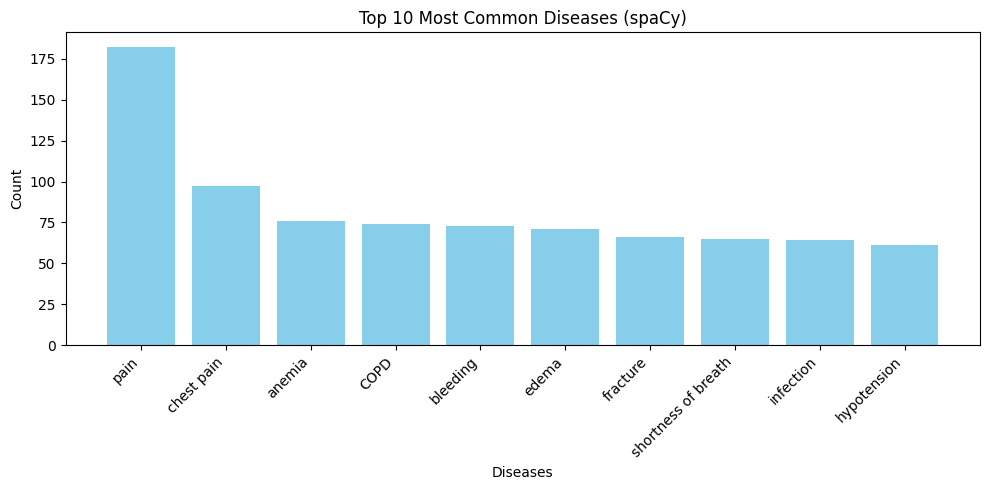

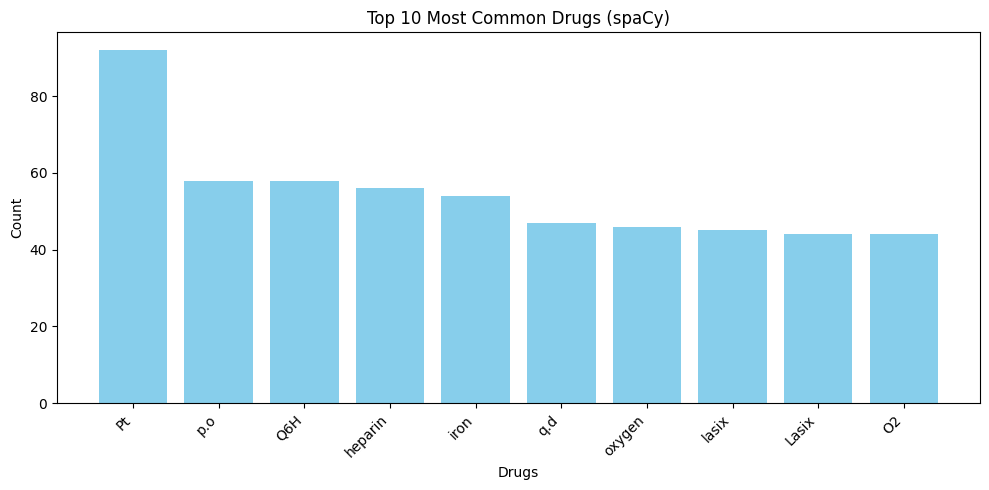

Total diseases detected (spaCy): 6388
Total drugs detected (spaCy): 4633


In [8]:
import spacy
import torch
from collections import Counter
import matplotlib.pyplot as plt

# Set the default device for PyTorch
device_spacy = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the spaCy model
nlp_sci_sm_spacy = spacy.load("en_ner_bc5cdr_md")

# Path to the text file
file_path_spacy = './output/combined_texts.txt'

# Initialize dictionaries to store unique entities and their counts
diseases_spacy = Counter()
drugs_spacy = Counter()

# Set the chunk size
chunk_size = 1000000

# Read and process the text file chunk by chunk
try:
    with open(file_path_spacy, 'r', encoding='utf-8') as file_spacy:
        while True:
            chunk_spacy = file_spacy.read(chunk_size)
            if not chunk_spacy:
                break
            
            # Process the chunk with spaCy model
            doc_spacy = nlp_sci_sm_spacy(chunk_spacy)
            for ent in doc_spacy.ents:
                if ent.label_ == "DISEASE":
                    diseases_spacy[ent.text] += 1
                elif ent.label_ == "CHEMICAL":
                    drugs_spacy[ent.text] += 1
            break
except FileNotFoundError:
    print(f"File not found: {file_path_spacy}")
except Exception as e_spacy:
    print(f"An error occurred: {e_spacy}")

# Count total entities
total_diseases_spacy = sum(diseases_spacy.values())
total_drugs_spacy = sum(drugs_spacy.values())

# Find the most common entities
most_common_diseases_spacy = diseases_spacy.most_common(10)
most_common_drugs_spacy = drugs_spacy.most_common(10)

# Function to plot bar charts
def plot_bar_chart(data, title, xlabel, ylabel, output_file):
    labels, values = zip(*data)
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

# Plot the most common diseases
plot_bar_chart(
    most_common_diseases_spacy,
    title='Top 10 Most Common Diseases (spaCy)',
    xlabel='Diseases',
    ylabel='Count',
    output_file='./output/top_10_diseases_spacy.png'
)

# Plot the most common drugs
plot_bar_chart(
    most_common_drugs_spacy,
    title='Top 10 Most Common Drugs (spaCy)',
    xlabel='Drugs',
    ylabel='Count',
    output_file='./output/top_10_drugs_spacy.png'
)

print(f"Total diseases detected (spaCy): {total_diseases_spacy}")
print(f"Total drugs detected (spaCy): {total_drugs_spacy}")


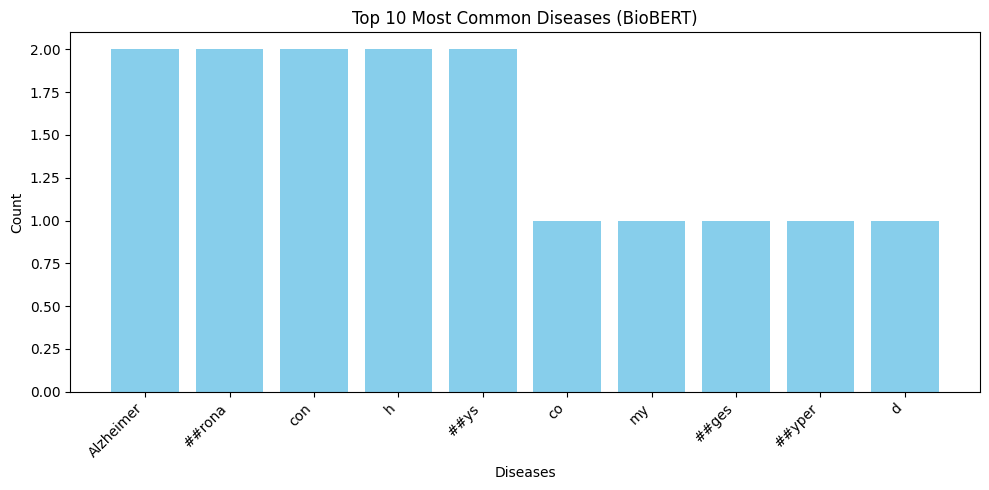

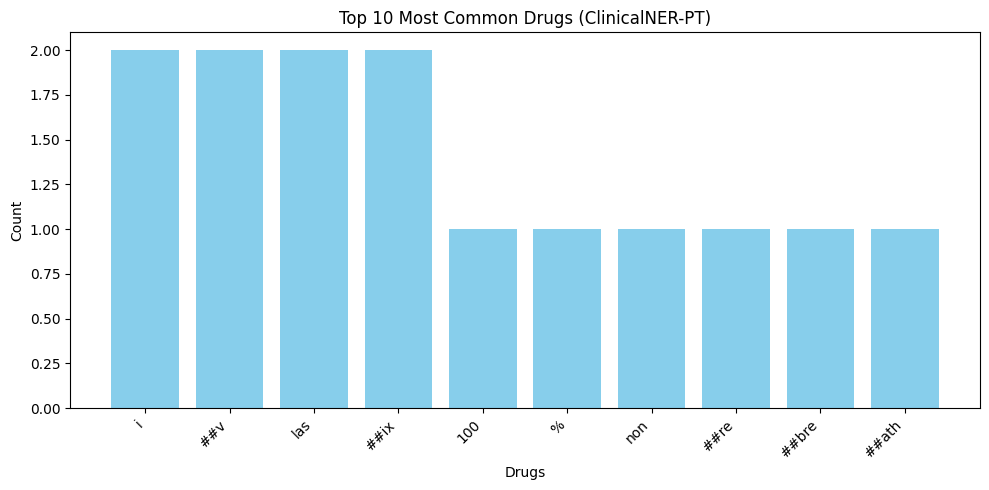

Total diseases detected: 24
Most common diseases: [('Alzheimer', 2), ('##rona', 2), ('con', 2), ('h', 2), ('##ys', 2), ('co', 1), ('my', 1), ('##ges', 1), ('##yper', 1), ('d', 1)]
Total drugs detected: 18
Most common drugs: [('i', 2), ('##v', 2), ('las', 2), ('##ix', 2), ('100', 1), ('%', 1), ('non', 1), ('##re', 1), ('##bre', 1), ('##ath', 1)]


In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from collections import Counter
import matplotlib.pyplot as plt

# Set the default device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BioBERT model and tokenizer for disease NER
biobert_model = AutoModelForTokenClassification.from_pretrained("ugaray96/biobert_ncbi_disease_ner").to(device)
biobert_tokenizer = AutoTokenizer.from_pretrained("ugaray96/biobert_ncbi_disease_ner")

# Load the ClinicalNER-PT model and tokenizer for drug NER
drug_model = AutoModelForTokenClassification.from_pretrained("pucpr/clinicalnerpt-chemical").to(device)
drug_tokenizer = AutoTokenizer.from_pretrained("pucpr/clinicalnerpt-chemical")

# Initialize NER pipelines for both disease and drug models
biobert_ner = pipeline("ner", model=biobert_model, tokenizer=biobert_tokenizer, device=0 if torch.cuda.is_available() else -1)
drug_ner = pipeline("ner", model=drug_model, tokenizer=drug_tokenizer, device=0 if torch.cuda.is_available() else -1)

# Path to the text file
file_path = './output/combined_texts.txt'

# Initialize dictionaries to store unique entities and their counts
diseases = Counter()
drugs = Counter()

# Set the chunk size
chunk_size = 1000000

# Read and process the text file chunk by chunk
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        while True:
            chunk = file.read(chunk_size)
            if not chunk:
                break

            # Process the chunk with BioBERT model for diseases
            biobert_entities = biobert_ner(chunk)
            for ent in biobert_entities:
                if ent['entity'] == "Disease":
                    diseases[ent['word']] += 1

            # Process the chunk with the ClinicalNER-PT model for drugs
            drug_entities = drug_ner(chunk)
            for ent in drug_entities:
                if ent['entity'] in ["B-ChemicalDrugs", "I-ChemicalDrugs"]:
                    drugs[ent['word']] += 1
            break
except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Count total entities
total_diseases = sum(diseases.values())
total_drugs = sum(drugs.values())

# Find the most common entities
most_common_diseases = diseases.most_common(10)
most_common_drugs = drugs.most_common(10)

# Function to plot bar charts
def plot_bar_chart(data, title, xlabel, ylabel, output_file):
    labels, values = zip(*data)
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

# Plot the most common diseases
plot_bar_chart(
    most_common_diseases,
    title='Top 10 Most Common Diseases (BioBERT)',
    xlabel='Diseases',
    ylabel='Count',
    output_file='./output/top_10_diseases_biobert.png'
)

# Plot the most common drugs
plot_bar_chart(
    most_common_drugs,
    title='Top 10 Most Common Drugs (ClinicalNER-PT)',
    xlabel='Drugs',
    ylabel='Count',
    output_file='./output/top_10_drugs_clinicalnerpt.png'
)

print(f"Total diseases detected: {total_diseases}")
print(f"Most common diseases: {most_common_diseases}")

print(f"Total drugs detected: {total_drugs}")
print(f"Most common drugs: {most_common_drugs}")


In [11]:
from collections import defaultdict

# Initialize dictionaries to store comparison results
comparison_diseases = defaultdict(lambda: {'spaCy_count': 0, 'BioBERT_count': 0})
comparison_drugs = defaultdict(lambda: {'spaCy_count': 0, 'BioBERT_count': 0})

# Update comparison dictionaries with results from spaCy
for disease, count in diseases_spacy.items():
    comparison_diseases[disease]['spaCy_count'] = count

for drug, count in drugs_spacy.items():
    comparison_drugs[drug]['spaCy_count'] = count

# Update comparison dictionaries with results from BioBERT
for disease, count in diseases.items():
    comparison_diseases[disease]['BioBERT_count'] = count

for drug, count in drugs.items():
    comparison_drugs[drug]['BioBERT_count'] = count

# Print comparison results for diseases
print("Disease Comparison:")
print(f"{'Disease':<30} {'spaCy Count':<10} {'BioBERT Count':<10}")
print("="*50)
for disease, counts in comparison_diseases.items():
    print(f"{disease:<30} {counts['spaCy_count']:<10} {counts['BioBERT_count']:<10}")

print("\nDrug Comparison:")
print(f"{'Drug':<30} {'spaCy Count':<10} {'BioBERT Count':<10}")
print("="*50)
for drug, counts in comparison_drugs.items():
    print(f"{drug:<30} {counts['spaCy_count']:<10} {counts['BioBERT_count']:<10}")


Disease Comparison:
Disease                        spaCy Count BioBERT Count
Alzheimer's dementia           5          0         
coronary artery
disease status post coronary artery bypass graft in [**2174**] with 1          0         
myocardial infarctions         2          0         
congestive heart failure       11         0         
hypertension                   33         0         
dyslipidemia                   1          0         
left arm weakness              2          0         
TIA                            5          0         
stroke                         17         1         
hypotensive                    18         0         
70s                            4          0         
congestive heart
failure       2          0         
Coronary artery disease        11         0         
Diabetes mellitus              7          0         
Dyslipidemia                   4          0         
Congestive heart failure       5          0         
q.                    